# HM2: Numerical Optimization for Logistic Regression.

### Name: Hayden Daly


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

In [1]:
import sys
sys.version

'3.8.1 (default, Jan 28 2020, 21:02:09) \n[Clang 10.0.1 (clang-1001.0.46.4)]'

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.07037971 -0.10461233  0.03171692 -0.02792899 -0.04772538 -0.16347163
  -0.03076192  0.03156698]]
test std = 
[[0.86103261 0.96198501 0.99413693 0.97749953 0.9040083  0.95026443
  1.06653049 1.06027876]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [6]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [7]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [8]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [9]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [10]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5887563148162827
Objective value at t=2 is 0.5485184921339815
Objective value at t=3 is 0.5275790762207705
Objective value at t=4 is 0.5147606066481752
Objective value at t=5 is 0.5061766851011429
Objective value at t=6 is 0.50010495750315
Objective value at t=7 is 0.4956513508815465
Objective value at t=8 is 0.4922991551056806
Objective value at t=9 is 0.48972646274913467
Objective value at t=10 is 0.48772160988692886
Objective value at t=11 is 0.48613974575186714
Objective value at t=12 is 0.4848786601882348
Objective value at t=13 is 0.48386445971968467
Objective value at t=14 is 0.48304265291844567
Objective value at t=15 is 0.48237238286076645
Objective value at t=16 is 0.4818225774079754
Objective value at t=17 is 0.48136931286630597
Objective value at t=18 is 0.4809939692569367
Objective value at t=19 is 0.48068191539279354
Objective value at t=20 is 0.48042155631094663
Objective value at t=21 is 0.48020363

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [11]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [12]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [13]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5404743018278384
Objective value at epoch t=1 is 0.5278006613487458
Objective value at epoch t=2 is 0.516699417360991
Objective value at epoch t=3 is 0.5195760355669349
Objective value at epoch t=4 is 0.5061211888810082
Objective value at epoch t=5 is 0.5079387657825908
Objective value at epoch t=6 is 0.5126798948774446
Objective value at epoch t=7 is 0.5102768094614475
Objective value at epoch t=8 is 0.5028409329553236
Objective value at epoch t=9 is 0.5014483398097129
Objective value at epoch t=10 is 0.49580870734600274
Objective value at epoch t=11 is 0.49693089208025815
Objective value at epoch t=12 is 0.49867367287017955
Objective value at epoch t=13 is 0.4892911639446025
Objective value at epoch t=14 is 0.49513353696017104
Objective value at epoch t=15 is 0.48678544366191634
Objective value at epoch t=16 is 0.4913280977560607
Objective value at epoch t=17 is 0.4901854396449613
Objective value at epoch t=18 is 0.4896639923549418
Objective value at

# 4. Compare GD with SGD

Plot objective function values against epochs.

<ipython-input-14-9b8d8f4cdfb5>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
<ipython-input-14-9b8d8f4cdfb5>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-14-9b8d8f4cdfb5>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Epochs', FontSize=20)
<ipython-input-14-9b8d8f4cdfb5>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('Objective Value', FontSize=20)
<ipython-input-14-9b8d8f4cdfb5>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 

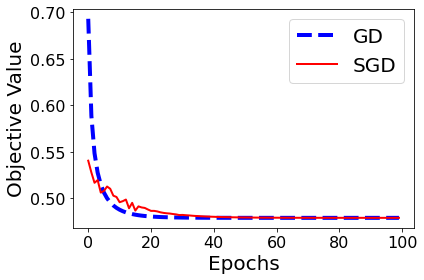

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [15]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [16]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2265625


In [17]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.1953125


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [18]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    d = xi.shape[1]
    yx = numpy.multiply(yi, xi) # b-by-d matrix
    yxw = numpy.dot(yx, w) # scalar
    
    # calculate objective function Q_i
    loss = numpy.sum(numpy.log(1 + numpy.exp(-yxw))) / b # scalar
    reg = (lam / 2) * numpy.sum(w * w) # scalar
    obj = loss + reg # scalar
    
    # calculate mb stochastic gradient
    g_loss = numpy.sum(numpy.divide(yx, 1 + numpy.exp(yxw)), axis=0).reshape(d, 1) # d-by-1 matrix
    g = (-g_loss / b) + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [19]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
        
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        batches = int(n / b)
        for i in range(batches):
            xi = x_rand[i*b:(i+1)*b, :] # 1-by-d matrix
            yi = y_rand[i*b:(i+1)*b, :] # scalar
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= batches
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [40]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.063 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5623133035414293
Objective value at epoch t=1 is 0.5030745086684656
Objective value at epoch t=2 is 0.49119819623868494
Objective value at epoch t=3 is 0.4864633587715964
Objective value at epoch t=4 is 0.48467580528523024
Objective value at epoch t=5 is 0.48327672833457636
Objective value at epoch t=6 is 0.48312539231066093
Objective value at epoch t=7 is 0.48209081685484456
Objective value at epoch t=8 is 0.4818307594101168
Objective value at epoch t=9 is 0.4812871978166829
Objective value at epoch t=10 is 0.48125597116988333
Objective value at epoch t=11 is 0.4808345363705209
Objective value at epoch t=12 is 0.48064107711472337
Objective value at epoch t=13 is 0.48061113441450215
Objective value at epoch t=14 is 0.4802673525914306
Objective value at epoch t=15 is 0.48020109625740737
Objective value at epoch t=16 is 0.4801095450983053
Objective value at epoch t=17 is 0.4799214362859683
Objective value at epoch t=18 is 0.4799471335155803
Objective val

In [49]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.46 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5772571882055122
Objective value at epoch t=1 is 0.5074970928086954
Objective value at epoch t=2 is 0.49309684078105853
Objective value at epoch t=3 is 0.4877424050430138
Objective value at epoch t=4 is 0.48458294660984114
Objective value at epoch t=5 is 0.4833937299845724
Objective value at epoch t=6 is 0.48229689651070834
Objective value at epoch t=7 is 0.48181531118701093
Objective value at epoch t=8 is 0.4816823064096236
Objective value at epoch t=9 is 0.4811572265232524
Objective value at epoch t=10 is 0.481017098481186
Objective value at epoch t=11 is 0.48090521521034146
Objective value at epoch t=12 is 0.4805098181587579
Objective value at epoch t=13 is 0.4803766269783029
Objective value at epoch t=14 is 0.4803311197848898
Objective value at epoch t=15 is 0.47997934568358547
Objective value at epoch t=16 is 0.48000702498420267
Objective value at epoch t=17 is 0.4800526677065105
Objective value at epoch t=18 is 0.4797178153385987
Objective value 

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

<ipython-input-50-9c32065997b7>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=2)
<ipython-input-50-9c32065997b7>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
<ipython-input-50-9c32065997b7>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', LineWidth=2)
<ipython-input-50-9c32065997b7>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line3, = plt.plot(epochs_mbsgd8, objvals_mbsgd64, '--y', LineWidth=2)
<ipython-input-50-9c32065997b7>:17: MatplotlibDepre

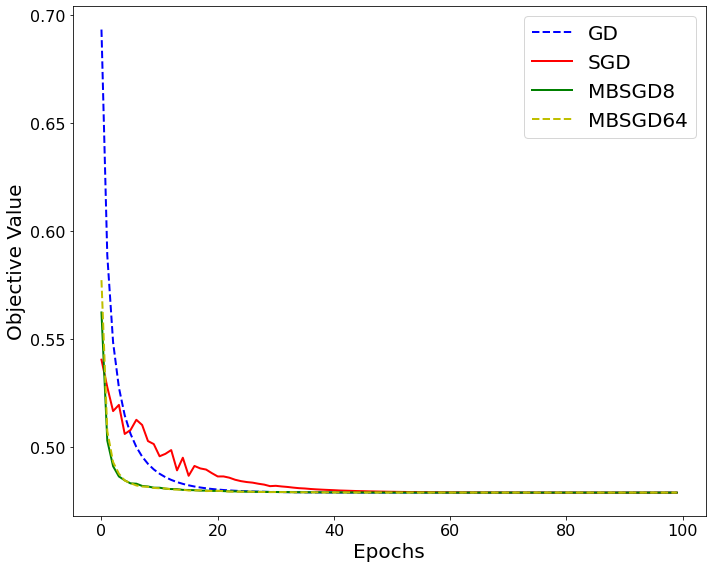

In [50]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=2)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', LineWidth=2)
line3, = plt.plot(epochs_mbsgd8, objvals_mbsgd64, '--y', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd.pdf', format='pdf', dpi=1200)